In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.externals import joblib
from collections import Counter

import pathlib as plib
import pdb
import types

In [2]:
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

In [3]:
#Globals
ROOT = plib.Path("/root/fastai/Playground/PytorchStarter/")
nRuns = 5 #number of test runs per unit
RSEED = 11;

In [4]:
cd $ROOT

/root/fastai/Playground/PytorchStarter


In [5]:
# To list all packages imported
list(imports())

['builtins',
 'builtins',
 'torch',
 'torch.nn',
 'torch.optim',
 'torch.nn.functional',
 'numpy',
 'matplotlib.pyplot',
 'pandas',
 'sklearn.externals.joblib',
 'pathlib',
 'pdb',
 'types']

### Load cancer dataset (binary classification)

In [6]:
from sklearn.datasets import load_breast_cancer

In [7]:
cancer_xy = load_breast_cancer()
cancer_x = cancer_xy.data
cancer_y = cancer_xy.target
print(cancer_x.shape, cancer_y.shape)
print("classes: ", np.unique(cancer_y))

(569, 30) (569,)
classes:  [0 1]


In [8]:
pd.DataFrame(cancer_x).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Define cancer dataset, dataloader

In [9]:
class CancerDataset(Dataset):
    def __init__(self, xy, ids, transform=None ):
        self.ids = ids
        self.len = len(ids)
        self.data = xy.data
        self.targets = xy.target
        self.transform = transform
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        """Returns a sample = [data[idx], targets[idx], idx]"""
        ID = self.ids[idx]
        sample = [self.data[ID], self.targets[ID], idx]
        
        if self.transform:
            sample = self.transform(sample)
        return sample

Divide the indices into train, dev, test


In [11]:
# cdataset = CancerDataset(cancer_xy, )

### Load LunaCsvDataset [NEW]

In [12]:
# import sys,os
# sys.path.append(os.path.abspath("../Scripts/"))
# from data_helpers import LunaCsvDataset, LunaPickleDataset

In [13]:
class LunaCsvDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        #todo: add ids, modify __len__
        """
        - csv_file (string): path to the csv file
        - root_dir (string or pathlib.Path object): directory with all the images
        - transform (callable, optional): optional transform to be applied to a sample
        """
        all_data = pd.read_csv(csv_file, header=0, index_col=0)
        # Filter out fruad datapoints
        is_not_fraud = [False if 'Fraud' in all_data.state[i] else True for i in range(len(all_data))]
        all_data = all_data[is_not_fraud]        
        self.data = np.array(all_data.drop('state', axis=1)) 
        self.target = np.array(all_data['state'])
        self.root_dir = root_dir
        self.transform = transform
    #todo
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        "returns a sample of format (feature 1,...,featureD, class)"
        return (self.data[idx, :], self.target[idx])
    
    #todo
    def set_label_dict(self, new_dict):
        self.label_dict = new_dict

class LunaPickleDataset(Dataset):
    def __init__(self, pk_file, ids, root_dir, transform=None):
        """
        - pk_file (string): path to the pickled file
        - root_dir (string): directory with all the images
        - transform (callable, optional): optional transform to be applied to a sample
        """
        all_data = joblib.load(pk_file) 
#         is_not_fraud = [False if 'Fraud' in all_data.state[i] else True for i in range(len(all_data))]
#         all_data = all_data[is_not_fraud]
        self.data = np.array(all_data.drop(['sn', 'state'], axis=1),
                            dtype=np.float32) # for compatibility with torch.FloatTensor
#         self.label_dict = {'KGB':0, 'Cracked':1, 'Repaired':2, 'NoPSA':0, }
        self.targets = np.array(all_data.state, 
                               dtype=np.int)
    
        self.ids = ids
        self.len = len(self.ids)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        "returns a sample of format [ [feature 1,...,featureD], target, idx]"
        ID = self.ids[idx]
        sample = (self.data[ID, :], self.targets[ID], idx)
        if self.transform:
            sample = self.transform(sample)
        return sample

### Load normalized kgb-repaired dataset

In [14]:
fpath = ROOT/'Data/DataMatrix/D_rr_rrr_kgb_badrepair_scaled_binary.pkl'
d = joblib.load(ROOT/fpath)
dataset = LunaPickleDataset(fpath, range(len(d)), root_dir=ROOT) #load entire dataset
print("Loaded Luna data with ONLY kgb and badrepair info")
print("data and target sizes: ", dataset.data.shape, dataset.targets.shape)
print("Labels: ", np.unique(dataset.targets)) #0: KGB or NoPSA, 1: BadRepair

FileNotFoundError: [Errno 2] No such file or directory: '/root/fastai/Playground/PytorchStarter/Data/DataMatrix/D_rr_rrr_kgb_badrepair_scaled_binary.pkl'

In [ ]:
print("mean: ", d.iloc[:,:-2].mean(axis=0).mean())
print("std: ", d.iloc[:,:-2].std(axis=0).mean())

d;

### Or, test with cancer dataset

In [15]:
dataset = CancerDataset(cancer_xy, range(len(cancer_xy)))

#### First, partition the dataset into train, dev, test sets

In [16]:
from sklearn.model_selection import train_test_split 
labels = dataset.targets
indices = range(len(labels))
train_dev_ids, test_ids = train_test_split(indices,
                                        stratify=labels,
                                        test_size=0.1, 
                                        random_state=RSEED) #stratified 

In [17]:
def print_counts(indices, labels, categories):
    #todo
    """check ratio of 0's and 1's in the labels selected by 'indices'
    - indices: 1D array for selected indices
    - labels: an array of 0s and 1s
    """
    filtered = labels[indices]
    if isinstance(filtered, torch.Tensor): filtered = filtered.numpy();
    if isinstance(filtered, list ): filtered = np.array(filtered);
        
    print([sum(filtered==categories[i]) for i in range(len(categories))])
    
def print_ratios(indices, labels, categories):
    #todo
    """check ratio of 0's and 1's in the labels selected by 'indices'
    - indices: 1D array for selected indices
    - labels: an array of 0s and 1s
    """
    filtered = labels[indices]
    if isinstance(filtered, torch.Tensor): filtered = filtered.numpy();
    if isinstance(filtered, list ): filtered = np.array(filtered);
    n = len(filtered)
        
    print([sum(filtered==categories[i])/n for i in range(len(categories))])

In [18]:
categories = np.unique(dataset.targets)
print_ratios(train_dev_ids, labels, categories)
print_ratios(test_ids, labels, categories)

[0.373046875, 0.626953125]
[0.3684210526315789, 0.631578947368421]


In [19]:
# partition train_ids into train_ids and dev_ids
train_dev_labels = labels[train_dev_ids]
indices = range(len(train_dev_ids))
train_ids, dev_ids = train_test_split(indices, 
                                     stratify=train_dev_labels,
                                     test_size=0.2,
                                     random_state=RSEED)
imax = max(max(train_ids, dev_ids))
imin = min(min(train_ids, dev_ids))
print(f"min and max indices should corresponds to 0 and {len(train_dev_labels)-1}: {imin, imax}")

# map it back to index to (the original) y
train_ids = np.array(train_dev_ids)[train_ids]
dev_ids = np.array(train_dev_ids)[dev_ids]

# make test_ids also a np array
test_ids = np.array(test_ids)

min and max indices should corresponds to 0 and 511: (3, 511)


In [20]:
# check ratios
for index_array in [train_ids, dev_ids, test_ids]:
    print_ratios(index_array, labels, categories)
    
        
# intersection check
s1 = set(train_ids); s2 = set(dev_ids); s3 = set(test_ids)
assert( len(s1.intersection(s2).intersection(s3)) == 0)

[0.3740831295843521, 0.6259168704156479]
[0.36893203883495146, 0.6310679611650486]
[0.3684210526315789, 0.631578947368421]


Train, Dev, Test sizes

In [21]:
print([len(ids) for ids in [train_ids, dev_ids, test_ids]])

[409, 103, 57]


Woohoo!

### Define Luna dataset and dataloader objects

First, define a transformation from numpy -> torch.FloatTensor

In [22]:
class npToFloatTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        datum, target, idx = sample #np.ndarray, an integer, idx to __getitem__ of Dataset
#         pdb.set_trace()
        
        datum = torch.from_numpy(datum).type(torch.float) #float32
        
        # BCLoss takes in both int and float tensor
        # CrossEntropyLoss requires target to be LongTensor, ie. int
        target = torch.tensor(target, dtype=torch.float)
        #todo: to int?
        return (datum, target, idx)

In [23]:
partition = {'train': train_ids, 
             'dev': dev_ids, 
             'test': test_ids}

In [24]:
# train_dataset = LunaPickleDataset(fpath, 
#                                   partition['train'], 
#                                   root_dir=ROOT,
#                                   transform=npToFloatTensor()
#                                  )
# dev_dataset = LunaPickleDataset(fpath, 
#                                 partition['dev'],
#                                 root_dir=ROOT,
#                                 transform=npToFloatTensor())

# test_dataset = LunaPickleDataset(fpath, 
#                                  partition['test'], 
#                                  root_dir=ROOT,
#                                  transform=npToFloatTensor())

In [25]:
train_dataset = CancerDataset(cancer_xy, 
                              partition['train'], 
                              transform=npToFloatTensor())
dev_dataset = CancerDataset(cancer_xy, 
                            partition['dev'],
                            transform=npToFloatTensor())

test_dataset = CancerDataset(cancer_xy, 
                            partition['test'], 
                            transform=npToFloatTensor())

In [26]:
dev_dataset[0]

(tensor([ 1.3690e+01,  1.6070e+01,  8.7840e+01,  5.7910e+02,  8.3020e-02,
          6.3740e-02,  2.5560e-02,  2.0310e-02,  1.8720e-01,  5.6690e-02,
          1.7050e-01,  5.0660e-01,  1.3720e+00,  1.4000e+01,  4.2300e-03,
          1.5870e-02,  1.1690e-02,  6.3350e-03,  1.9430e-02,  2.1770e-03,
          1.4840e+01,  2.0210e+01,  9.9160e+01,  6.7060e+02,  1.1050e-01,
          2.0960e-01,  1.3460e-01,  6.9870e-02,  3.3230e-01,  7.7010e-02]),
 tensor(1.),
 0)

In [27]:
#2. new dataloader instance
data_params = {'batch_size': 32,
              'shuffle': True,
              'num_workers':4}
train_loader = DataLoader(dataset=train_dataset, **data_params)
heavy_train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_ids), shuffle=False)

# train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_ids), shuffle=True)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=len(dev_ids), shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_ids), shuffle=False)

#### Test loaders

In [28]:
for loader in [train_loader, dev_loader, test_loader ]:
    print('num of cycles: ', len(loader))
#     dataiter = iter(loader)
#     print('dtype: ', type(dataiter.next()[0][0]))
#     print(dataiter.next())


num of cycles:  13
num of cycles:  1
num of cycles:  1


Ready!

In [29]:
# Wrong way to set initial weights 
# because no inplace functions are allowed for Variables with'requires_grad=True'
# Ref: https://discuss.pytorch.org/t/how-to-initiate-parameters-of-layers/1460
def wrong_weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.normal_() # error! 
        m.bias.normal_() # error!
        
def weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(RSEED)
        m.weight.data.normal_() 
        m.bias.data.normal_() 
            #alternatively set initial bias to zero
            # m.bias.data.fill_(0)
        

## 3. Try a deeper network

Simple batch norm layer 

In [30]:
N,D =  train_dataset.len, train_dataset.data.shape[1]
criterion = nn.BCELoss(size_average=True)

In [31]:
class DeepBCModel(nn.Module):
    def __init__(self, dims, 
                 hidden_activation=nn.ReLU(), 
                 output_activation=nn.Sigmoid()):
        """
        dims: a list of dimensions of layer. [inDims, H1, H2,...].
        It doesn't include the output layer's size, which is fixed to 1"""
        super(DeepBCModel,self).__init__()
        
        self.__build_layers__(dims)
        self.n_layers = len(dims)
        self.n_batch_norms = self.n_layers - 1 # Q:don't need for the last layer(right before softmax)
        
#         self.batch_norm = nn.BatchNorm1d() #todo
        self.h_activation = hidden_activation
        self.o_activation = output_activation
        
    def __build_layers__(self, dims):
#         assert(len(self.layers) == 0)
#         for i in range(len(dims)-1):
#             self.add_module(f'h{i}', self.h_activation(nn.Linear(dims[i],dim[i+1])))
#         self.add_module(f'h{len(dim)-1}', self.o_activation(nn.Linear(dims[-1],1)))
                            
        for i in range(len(dims)-1):
            self.add_module(f'li{i}', nn.Linear(dims[i],dims[i+1]))
            self.add_module(f'bn{i}', nn.BatchNorm1d(dims[i+1]))
        self.add_module(f'li{len(dims)-1}', nn.Linear(dims[-1],1))
        
#     def forward(self, x):
#         y_pred = x
        
#         for (mname, m) in self.named_children():
#             if not isinstance(m, nn.Linear):
# #                 print(mname, ': pass')
#                 continue
            
#             if (str(self.n_layers-1) in mname):
# #                 print(mname, ': last layer')
#                 act = self.o_activation
#             else:
# #                 print(mname, ": middle layer" )
#                 act = lambda x: nn.BatchNorm1d()(x)self.h_activation(nn.BatchNorm1d())
                
#             y_pred = act(m(y_pred))
#         return y_pred
    def forward(self, x):
        y_pred = x

        for i in range(self.n_layers - 1): #exclude the last weight
            li = getattr(self, f"li{i}")
            bn = getattr(self, f"bn{i}")
            y_pred = self.h_activation(bn(li(y_pred)))

        li = getattr(self, f"li{self.n_layers-1}")
        y_pred = self.o_activation(li(y_pred))

        return y_pred


In [32]:
def get_train_loss(model, criterion, train_dataset, exclude_indices):
    """
    Compute loss on training dataset except data indexed at
    exclude_indices.
    Args:
    - model: trained model with forward function
    - criterion: loss function that takes in (ypred, y)
    - train_dataset (Dataset): training dataset 
    - exclude_indices: indices to exclude from train_dataset 
        when computing the loss, eg: batch indices used to 
        fit the current model
    """
    n = len(train_dataset)
    if isinstance(exclude_indices, torch.Tensor):
        exclude_indices = exclude_indices.numpy()
    include_indices = [i for i in range(n) if i not in exclude_indices]
    samples = train_dataset[include_indices]
    x = samples[0]
    y = samples[1]
#     pdb.set_trace()
#     x_tensor = torch.tensor(x)
#     y_tensor = torch.stack(y)
#     pdb.set_trace()
    with torch.no_grad():
        ypred = model(x).type_as(y)
        loss = criterion(ypred, y).item()
    return loss  

In [33]:
def get_loss_on_entire_dataset(model, criterion, loader):
    """Assumes dataset has a batch_size == len(dataset),
    ie. one iter results in iterating the entire dataset."""
    n = len(loader.dataset)
    assert(n == loader.batch_size)
    
#     print(model.li4.bias[:10])
#             pdb.set_trace()

    with torch.no_grad():
        loss = 0
        acc = 0 #general acc
        hit_accs = [] #acc per label

        for x, y, _ in loader:
            ypred = model(x).view(y.size()).type_as(y)
            loss = criterion(ypred, y).item()
            
            # make a decision at 0.5
            # boolean tensor is uint8 type. Cast it to tensor.float32
            decision = (ypred > 0.5).view(y.size()).type(y.dtype)
            isCorrect = (decision==y).numpy()
            acc = sum(isCorrect)/len(isCorrect)

            # 0->0 accuracy, 1->1 accuracy
            for label in y.unique():
                hit_count = [1 for i in range(n) if decision[i]==label and y[i]==label]
                hit_acc = sum(hit_count) / (y==label).sum().item() #sum(y==label).item()
                hit_accs.append(hit_acc)
    return [loss, acc, hit_accs]

In [34]:
def show_weights(model, ncols=3, figsize=(20,10)):
    # visualize weights
    n = model.n_layers
#     pdb.set_trace()
    nrows = int(np.floor(n/ncols))
    f,axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    i = 0
    for mname,m in model.named_children():
        if isinstance(m, nn.Linear):
            w = m.weight.data.numpy()
            if w.shape[0] == 1 or w.shape[1] == 1:
                w = w.reshape((-1,10))

            print (f'{mname}: {w.min(), w.max()}')
            axes[i].set_title(mname)
            axes[i].axis('off')
            axes[i].imshow(w)
            i += 1
    plt.show()

- Test DeepBCModel constructor

In [35]:
N,D =  train_dataset.len, train_dataset.data.shape[1]

dims = [D, 200,200,200]
M = DeepBCModel(dims)
criterion = nn.BCELoss(size_average=True)

print(M)
print(M.n_layers)

DeepBCModel(
  (li0): Linear(in_features=30, out_features=200, bias=True)
  (bn0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (li1): Linear(in_features=200, out_features=200, bias=True)
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (li2): Linear(in_features=200, out_features=200, bias=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (li3): Linear(in_features=200, out_features=1, bias=True)
  (h_activation): ReLU()
  (o_activation): Sigmoid()
)
4


In [36]:
for m in M.children():
    print(m)

Linear(in_features=30, out_features=200, bias=True)
BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Linear(in_features=200, out_features=200, bias=True)
BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Linear(in_features=200, out_features=200, bias=True)
BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Linear(in_features=200, out_features=1, bias=True)
ReLU()
Sigmoid()


In [37]:
# check forward function
dataiter = iter(train_loader)
x1, y1, idx = dataiter.next()

In [38]:
M(x1);

- Test get_train_loss


In [39]:
excludes = range(32)
get_train_loss(M, criterion, train_dataset, excludes)

/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([377])) that is different to the input size (torch.Size([377, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0.7002192735671997

### Experiments

In [40]:
# Hyperparameters
learning_rate = 0.0001
nEpoch = 1000
H1 = 100; H2 = 100;# H3 = 50; H4 = 50
dims = [D, H1, H2]#, H3, H4]
plt.ion() # turn on interactive mode

In [41]:
model = DeepBCModel(dims)
model.apply(weight_init)

DeepBCModel(
  (li0): Linear(in_features=30, out_features=100, bias=True)
  (bn0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (li1): Linear(in_features=100, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (li2): Linear(in_features=100, out_features=1, bias=True)
  (h_activation): ReLU()
  (o_activation): Sigmoid()
)

li0: (-3.4707286, 3.6032736)
li1: (-3.58521, 3.6032736)
li2: (-2.0597744, 2.995054)


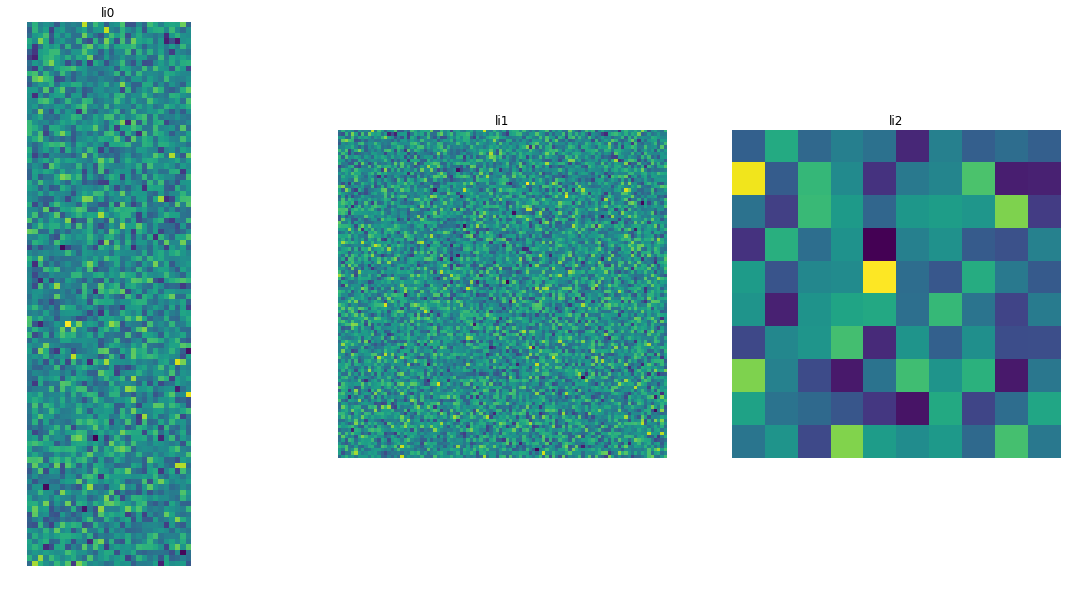

In [42]:
# visualize first layer's initial weight
show_weights(model)

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Save and load model   
See [sor](http://bit.ly/2uo4zt9), [pytorch forum](http://bit.ly/2zrvTg1)
1. Save 
```pytorch
torch.save(the_model.state_dict(), PATH)
```
2. Load
```pytorch
the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))
```

epoch 0


/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([377])) that is different to the input size (torch.Size([377, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/root/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([384])) that is different to the input size (torch.Size([384, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


train loss, acc: (1.0123251676559448, 0.6)
epoch train loss: 1.0055686235427856
dev loss, acc: (1.0306003093719482, 0.4854368932038835)
li0: (-3.471787, 3.6042635)
li1: (-3.5864377, 3.6020405)
li2: (-2.0610645, 2.993766)


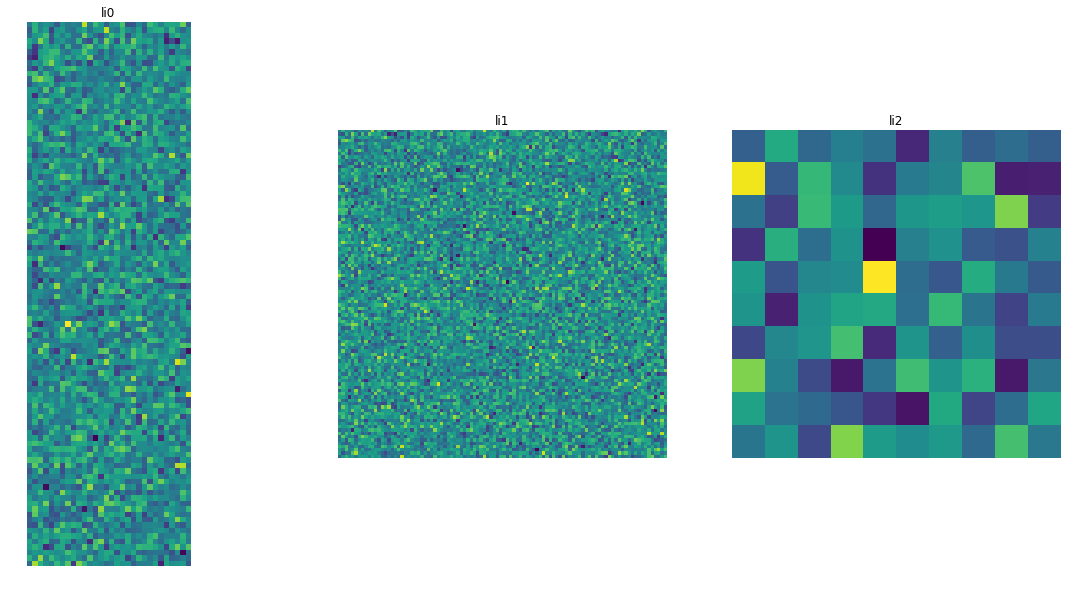

epoch 49
train loss, acc: (0.16890710592269897, 0.72)
epoch train loss: 0.15856817364692688
dev loss, acc: (0.17697282135486603, 0.9320388349514563)
li0: (-3.4886687, 3.6235077)
li1: (-3.602759, 3.5853932)
li2: (-2.0792933, 2.9778774)


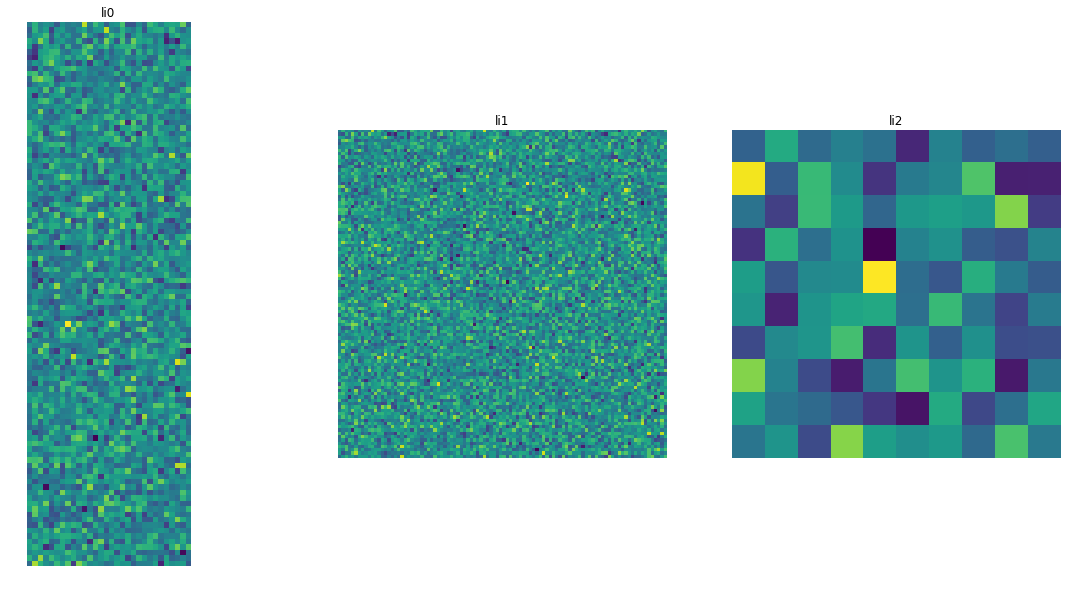

epoch 98
train loss, acc: (0.1327693611383438, 0.96)
epoch train loss: 0.13264425098896027
dev loss, acc: (0.15302804112434387, 0.941747572815534)
li0: (-3.5012271, 3.638831)
li1: (-3.6066349, 3.586727)
li2: (-2.0814092, 2.975993)


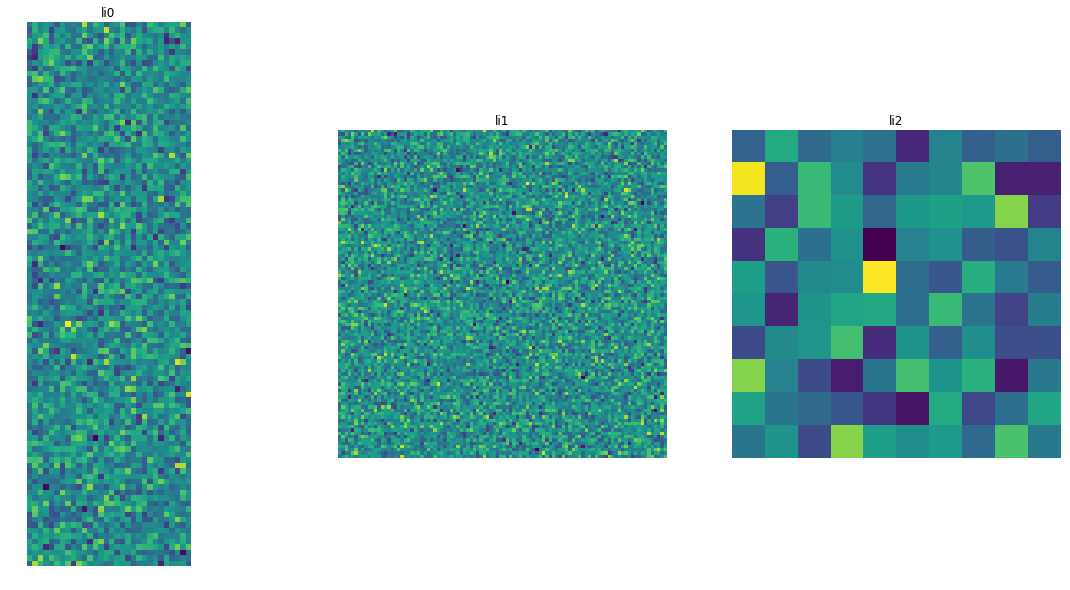

epoch 147
train loss, acc: (0.12104735523462296, 0.96)
epoch train loss: 0.11657220870256424
dev loss, acc: (0.14614097774028778, 0.941747572815534)
li0: (-3.5109138, 3.6518624)
li1: (-3.6111486, 3.5864058)
li2: (-2.0831056, 2.9744897)


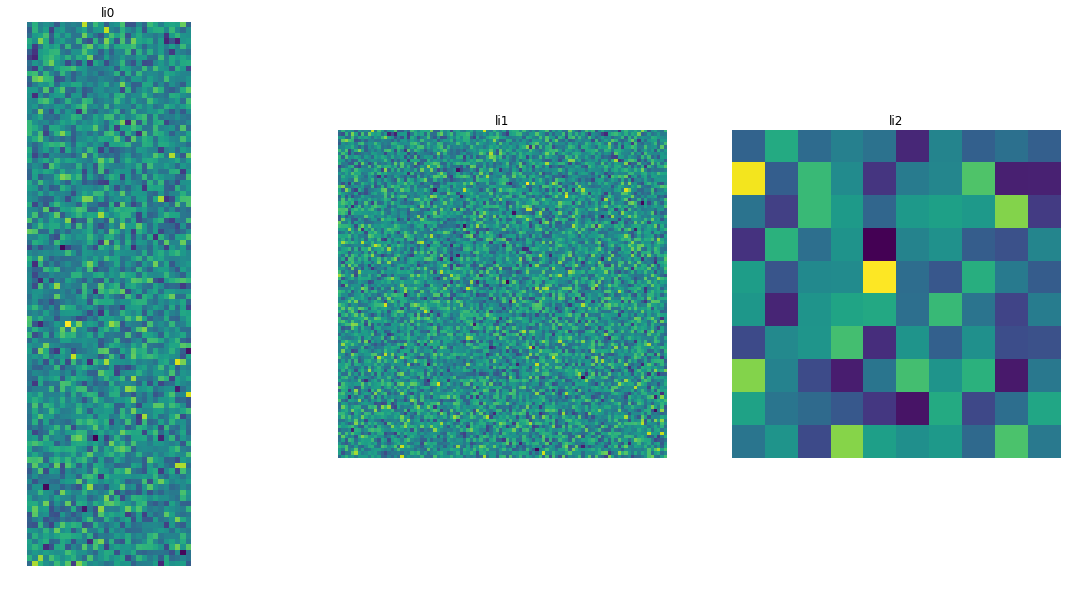

epoch 196
train loss, acc: (0.10718715935945511, 1.0)
epoch train loss: 0.10453614592552185
dev loss, acc: (0.14277136325836182, 0.941747572815534)
li0: (-3.520288, 3.6658235)
li1: (-3.6134653, 3.5875156)
li2: (-2.0853965, 2.9733686)


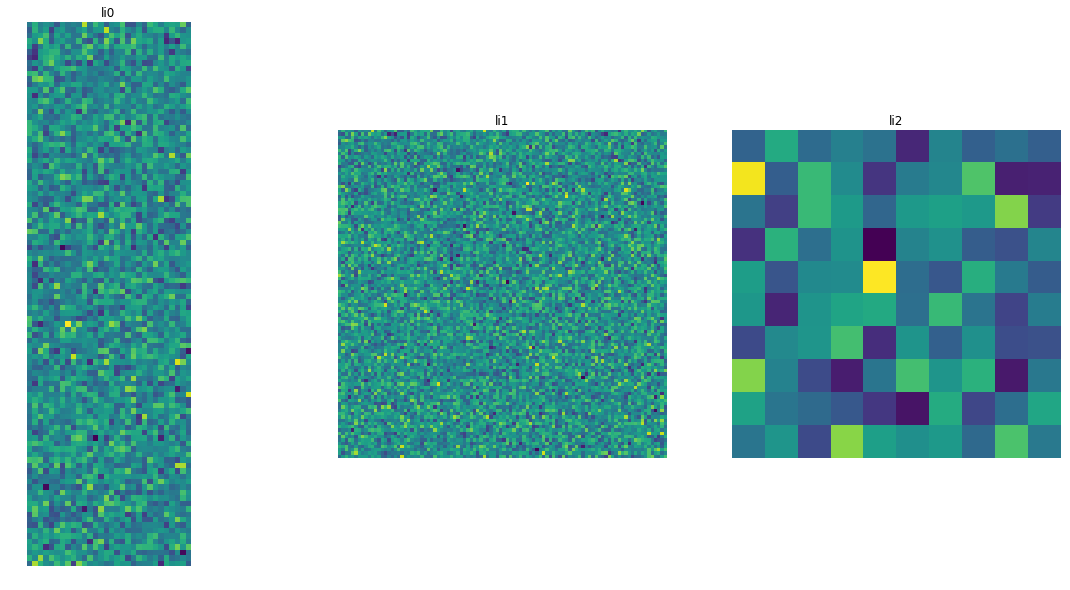

epoch 245
train loss, acc: (0.0970522090792656, 0.96)
epoch train loss: 0.0964781865477562
dev loss, acc: (0.13982684910297394, 0.9514563106796117)
li0: (-3.5258176, 3.6814902)
li1: (-3.6141865, 3.589366)
li2: (-2.0870042, 2.9729295)


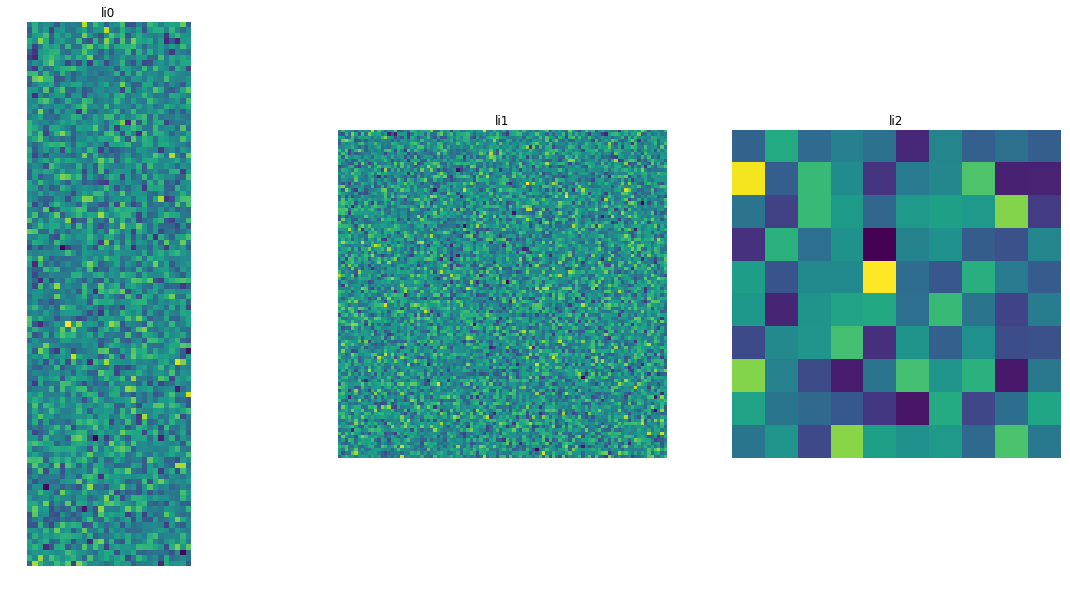

epoch 294
train loss, acc: (0.08935829997062683, 0.96)
epoch train loss: 0.08984553068876266
dev loss, acc: (0.13974297046661377, 0.941747572815534)
li0: (-3.5332613, 3.6949532)
li1: (-3.6145678, 3.590765)
li2: (-2.0886476, 2.972327)


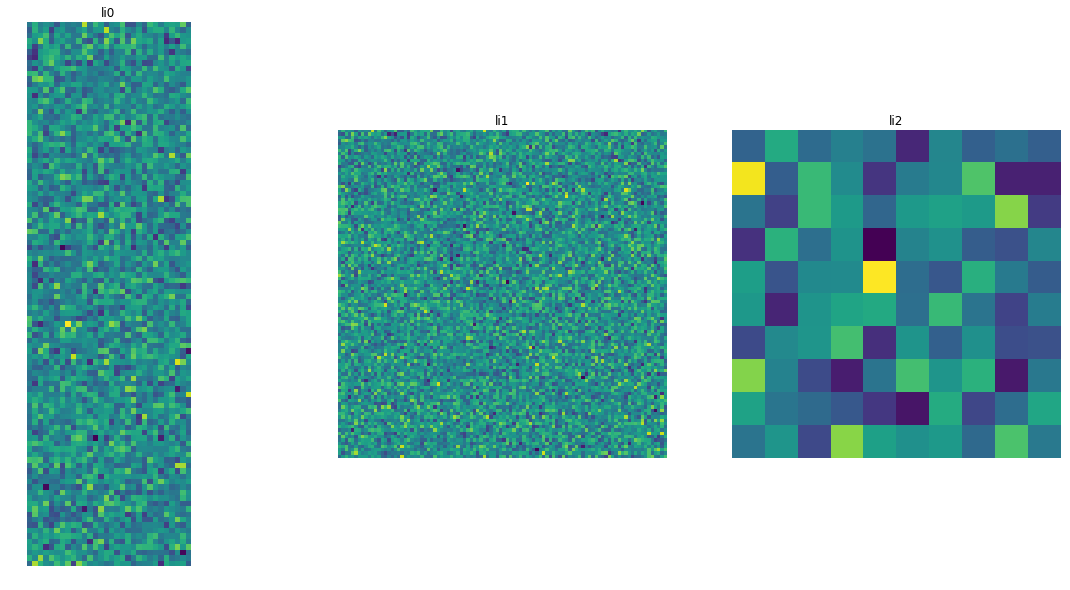

epoch 343
train loss, acc: (0.08441513031721115, 1.0)
epoch train loss: 0.08439496159553528
dev loss, acc: (0.14066793024539948, 0.941747572815534)
li0: (-3.5337698, 3.7132387)
li1: (-3.6134045, 3.592502)
li2: (-2.090767, 2.972118)


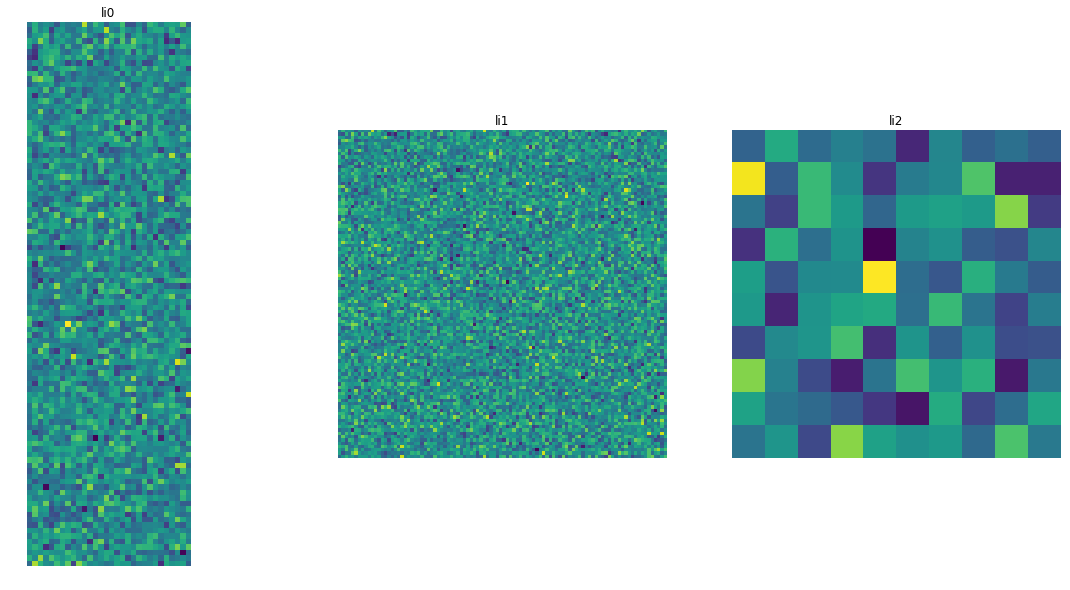

epoch 392
train loss, acc: (0.07820731401443481, 0.96)
epoch train loss: 0.07917382568120956
dev loss, acc: (0.1442432552576065, 0.9514563106796117)
li0: (-3.5327823, 3.727601)
li1: (-3.6128654, 3.5960166)
li2: (-2.0951138, 2.9707816)


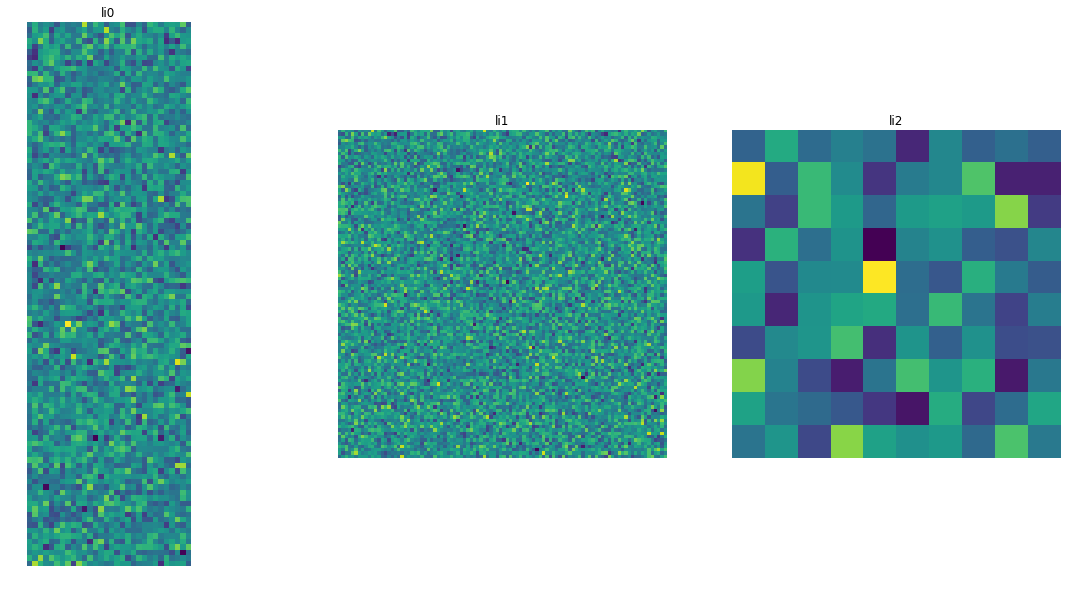

epoch 441
train loss, acc: (0.07815708965063095, 1.0)
epoch train loss: 0.07479992508888245
dev loss, acc: (0.14345581829547882, 0.9514563106796117)
li0: (-3.536547, 3.740092)
li1: (-3.6142344, 3.5999722)
li2: (-2.097103, 2.9708896)


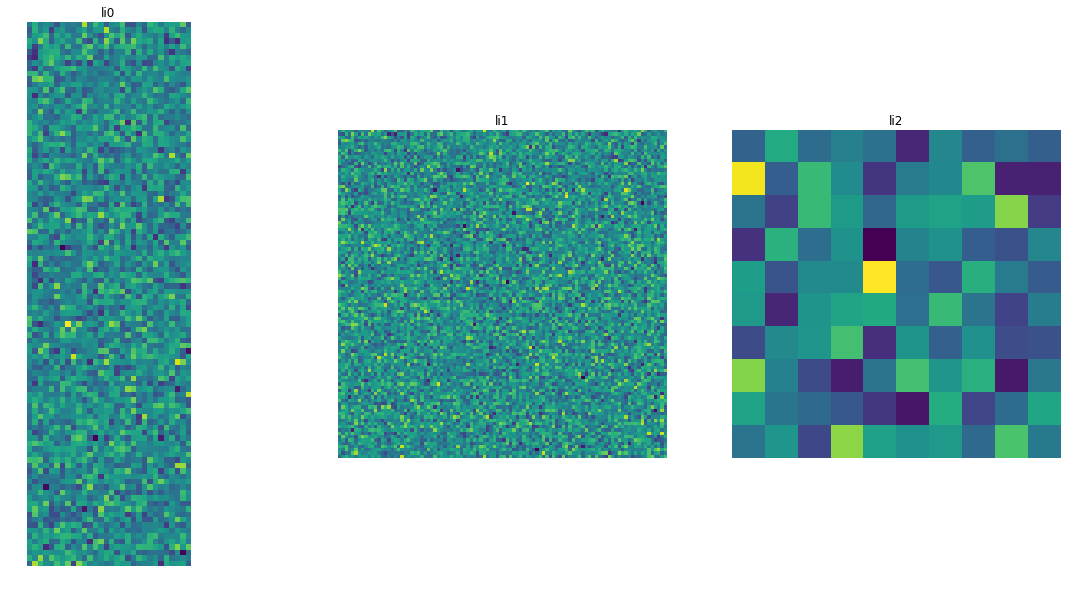

epoch 490
train loss, acc: (0.07336161285638809, 0.96)
epoch train loss: 0.07202696055173874
dev loss, acc: (0.1443389654159546, 0.9514563106796117)
li0: (-3.5678608, 3.7567413)
li1: (-3.6126637, 3.6024854)
li2: (-2.0991786, 2.9709992)


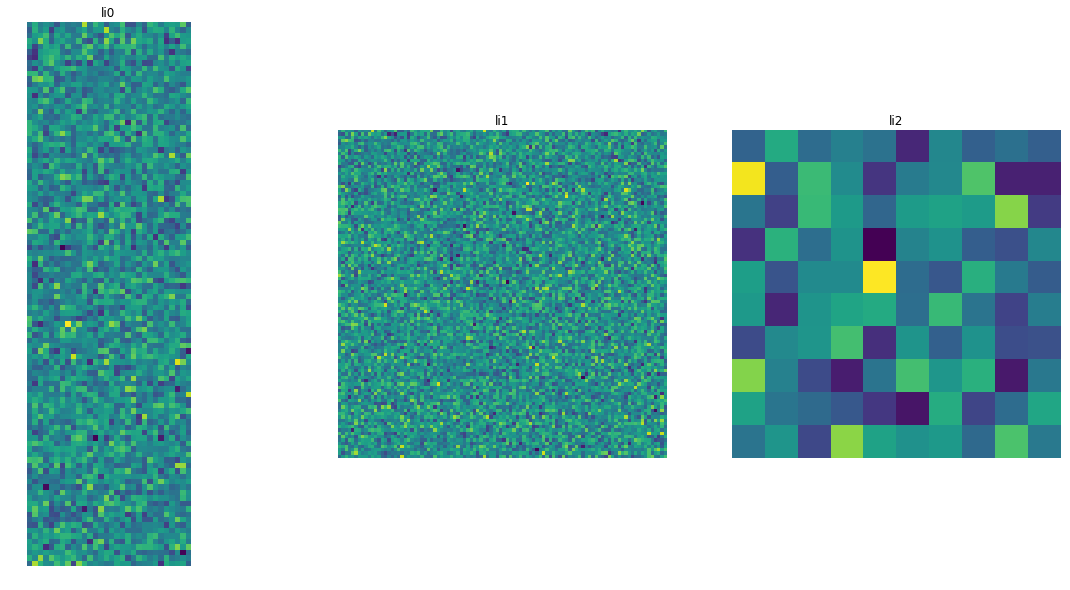

epoch 539
train loss, acc: (0.07025927305221558, 0.96)
epoch train loss: 0.06989583373069763
dev loss, acc: (0.14268873631954193, 0.9514563106796117)
li0: (-3.5982246, 3.7674644)
li1: (-3.612148, 3.6047728)
li2: (-2.1021123, 2.9720762)


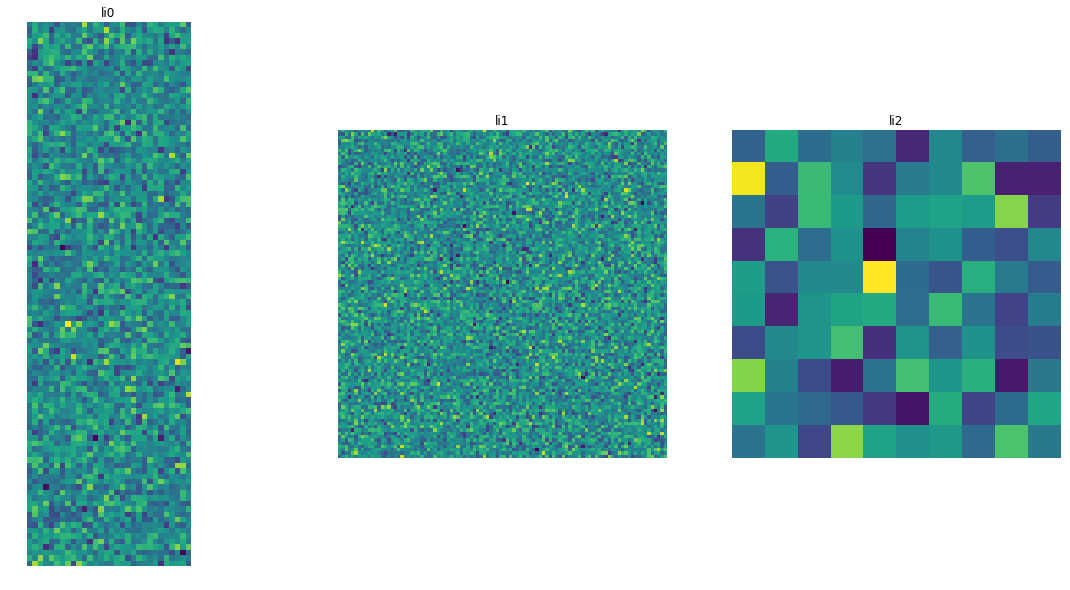

epoch 588
train loss, acc: (0.06876443326473236, 1.0)
epoch train loss: 0.066895492374897
dev loss, acc: (0.13980399072170258, 0.9611650485436893)
li0: (-3.63082, 3.7758653)
li1: (-3.6113403, 3.6068275)
li2: (-2.1054685, 2.97279)


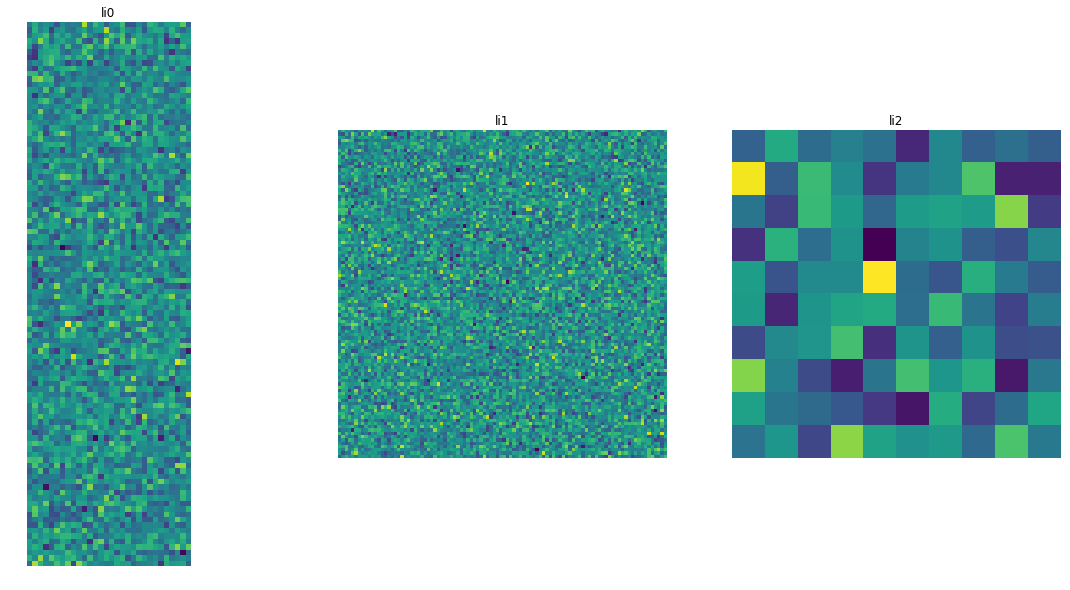

epoch 637
train loss, acc: (0.06075500324368477, 0.92)
epoch train loss: 0.06545901298522949
dev loss, acc: (0.13815386593341827, 0.9611650485436893)
li0: (-3.6608646, 3.7851615)
li1: (-3.6086, 3.6094832)
li2: (-2.1075828, 2.9750142)


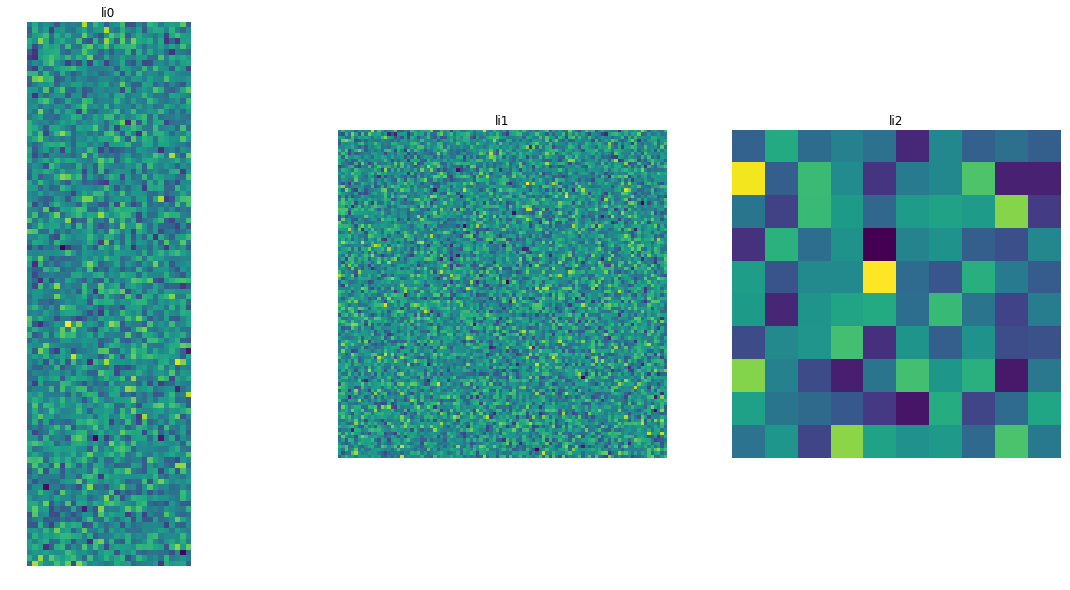

epoch 686
train loss, acc: (0.06503274291753769, 0.96)
epoch train loss: 0.06482257694005966
dev loss, acc: (0.14029480516910553, 0.9514563106796117)
li0: (-3.691366, 3.791955)
li1: (-3.6042984, 3.6118188)
li2: (-2.1114314, 2.9768953)


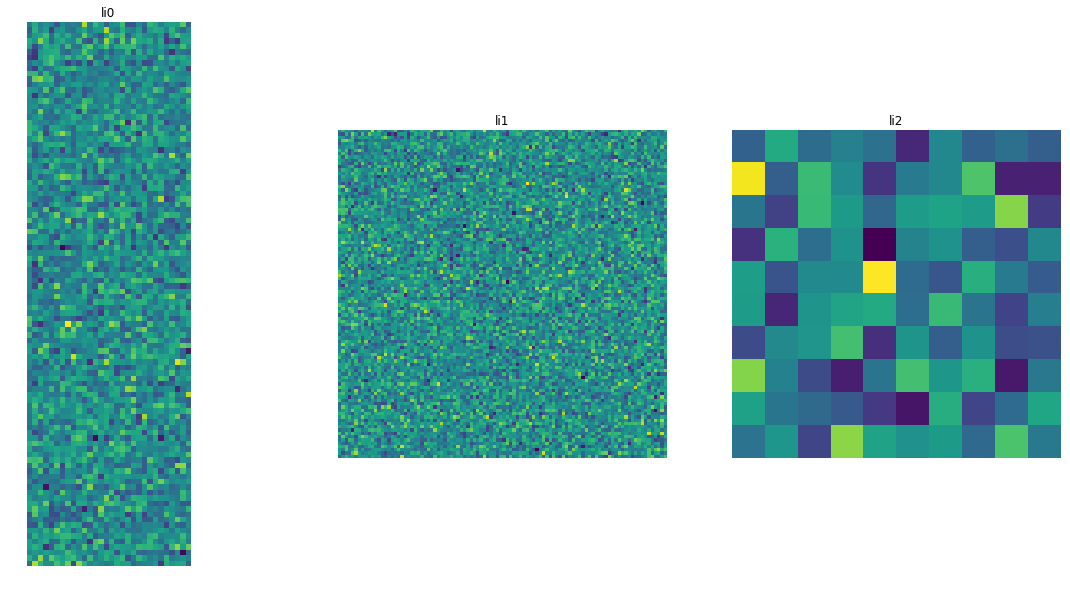

epoch 735
train loss, acc: (0.06082911416888237, 0.96)
epoch train loss: 0.06251763552427292
dev loss, acc: (0.14349472522735596, 0.9514563106796117)
li0: (-3.7252884, 3.7961862)
li1: (-3.6042378, 3.6159737)
li2: (-2.1109664, 2.9820745)


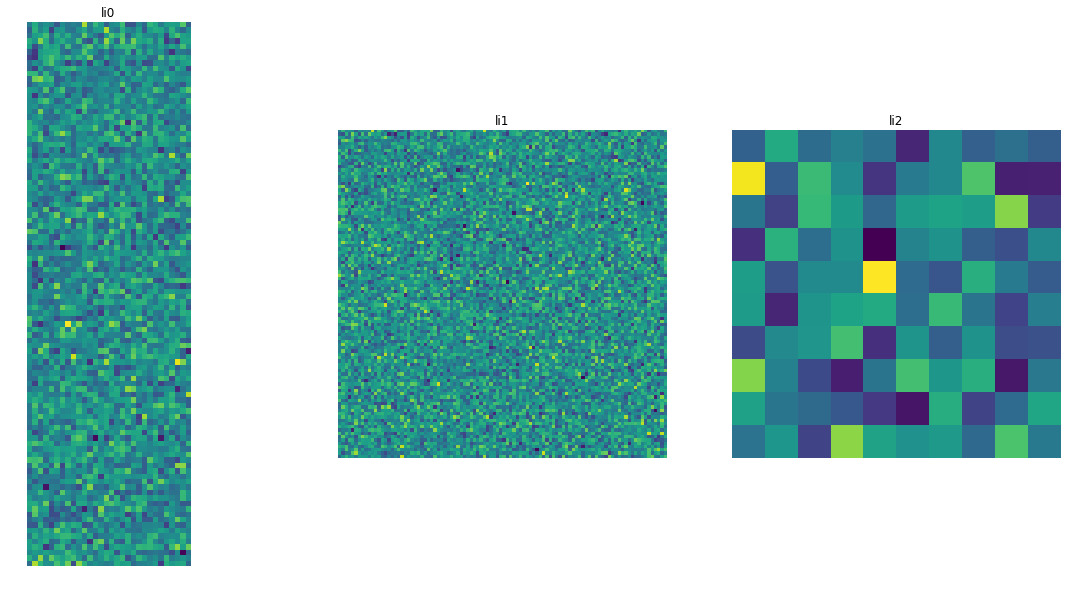

epoch 784
train loss, acc: (0.06082560494542122, 0.96)
epoch train loss: 0.060977522283792496
dev loss, acc: (0.1395721584558487, 0.9611650485436893)
li0: (-3.7572875, 3.795476)
li1: (-3.599758, 3.6172838)
li2: (-2.113949, 2.9842894)


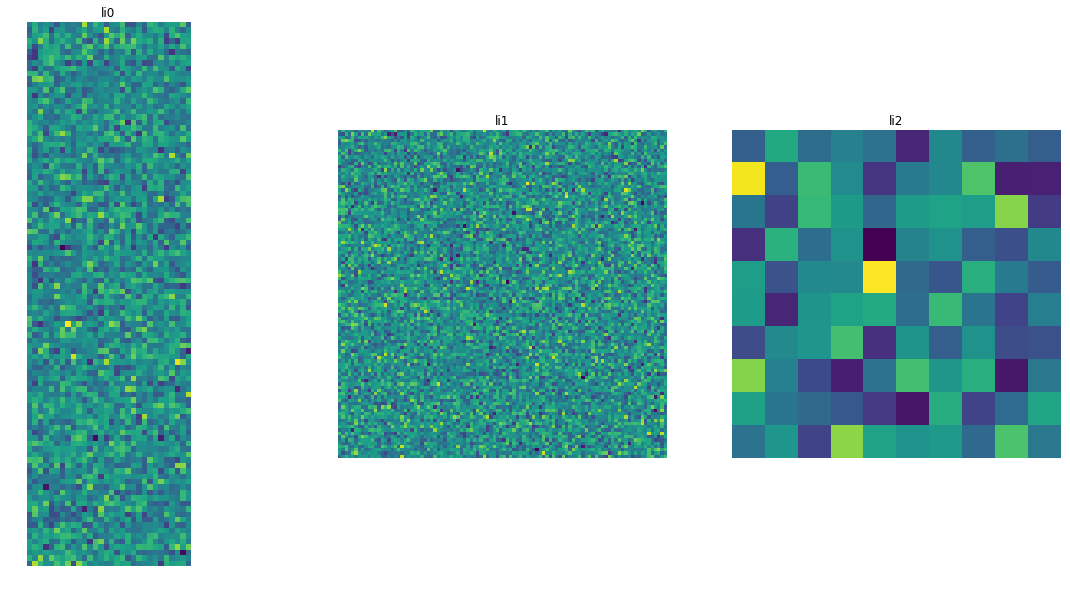

epoch 833
train loss, acc: (0.05986062064766884, 0.92)
epoch train loss: 0.060517214238643646
dev loss, acc: (0.1422610580921173, 0.9514563106796117)
li0: (-3.7901123, 3.7979238)
li1: (-3.5929527, 3.6207616)
li2: (-2.1140435, 2.988649)


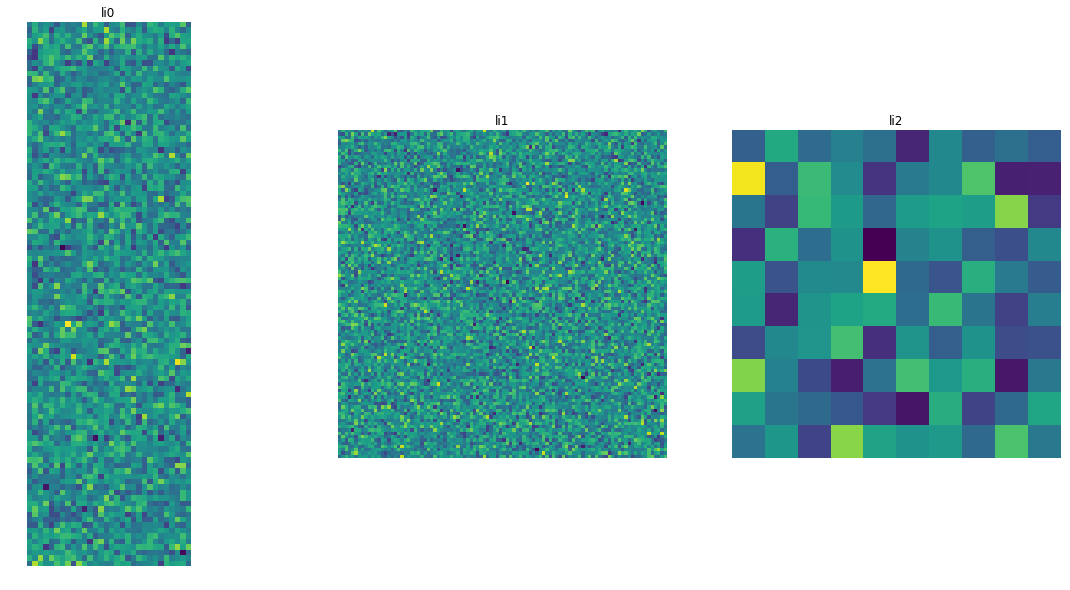

epoch 882
train loss, acc: (0.056321073323488235, 0.96)
epoch train loss: 0.05762389674782753
dev loss, acc: (0.13827615976333618, 0.9611650485436893)
li0: (-3.818722, 3.7983482)
li1: (-3.5899153, 3.6236193)
li2: (-2.116624, 2.9938886)


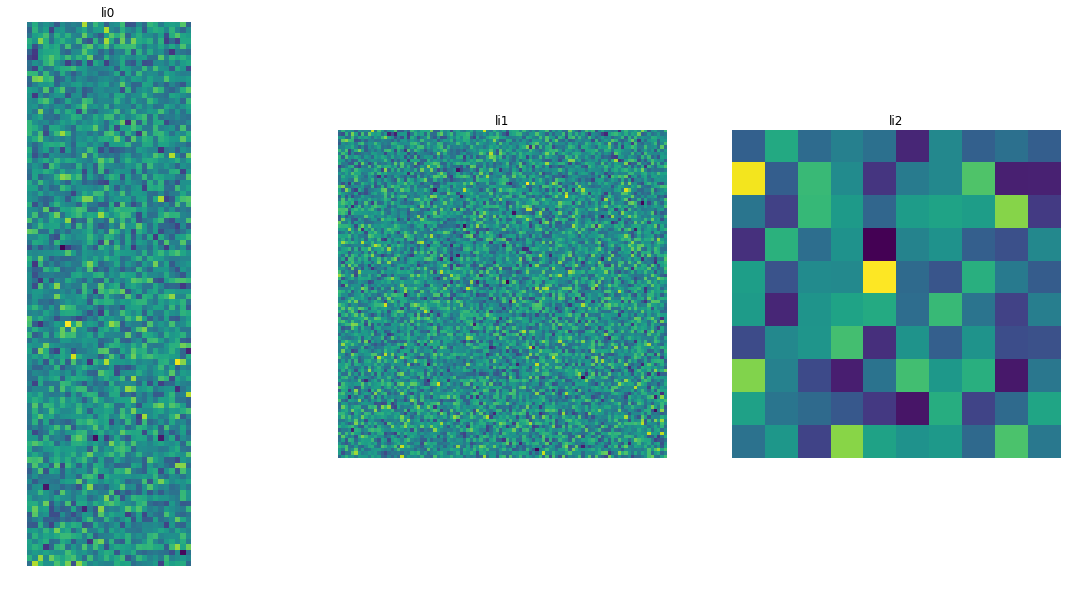

epoch 931
train loss, acc: (0.056001003831624985, 0.96)
epoch train loss: 0.05669413506984711
dev loss, acc: (0.1399877667427063, 0.9514563106796117)
li0: (-3.8484335, 3.7983363)
li1: (-3.5839243, 3.6253676)
li2: (-2.1184227, 2.9964278)


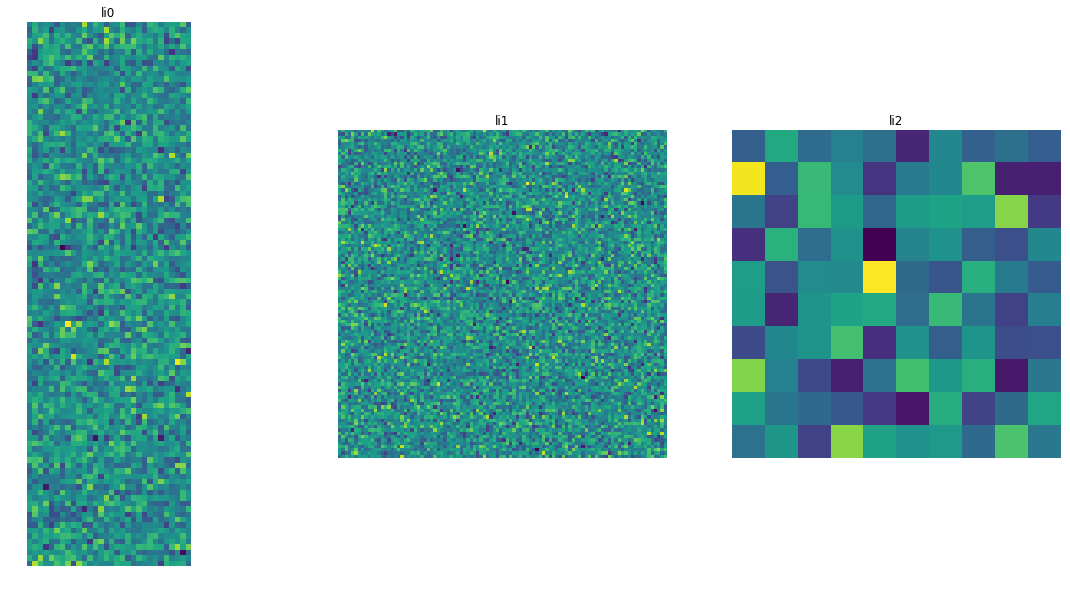

epoch 980
train loss, acc: (0.058610737323760986, 1.0)
epoch train loss: 0.056609105318784714
dev loss, acc: (0.14436310529708862, 0.9514563106796117)
li0: (-3.8757722, 3.7937763)
li1: (-3.5810096, 3.6258366)
li2: (-2.1190763, 3.0009282)


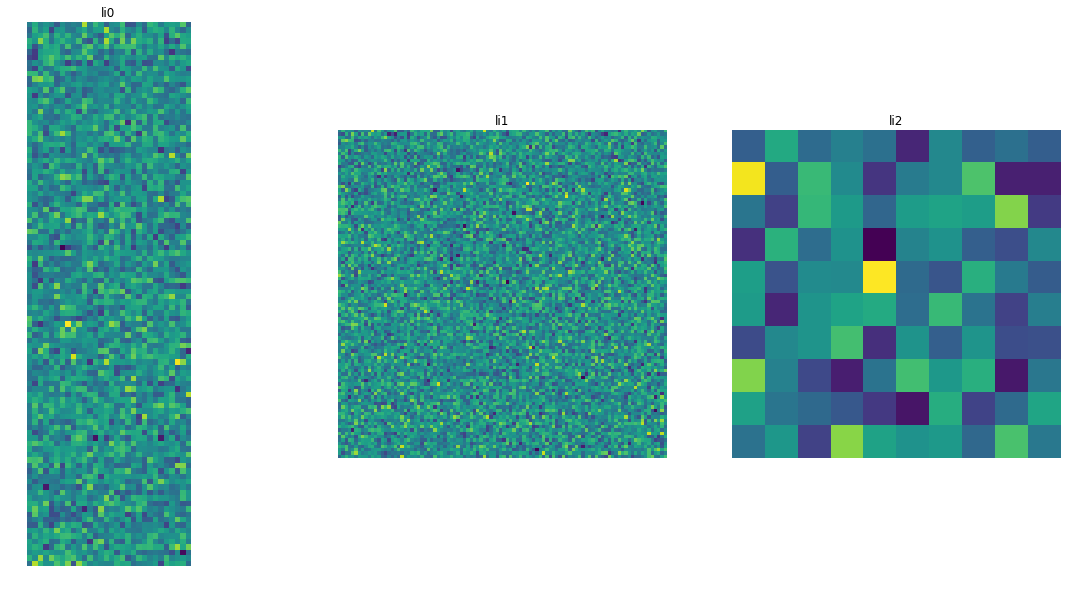

In [44]:
# Train
debug = False
verbose = True

# loss and acc from each batch (ie. per cycle)
batch_ls = []
train_ls = []
batch_accs = []
batch_hit_accs = []

# loss and acc from each epoch (ie. per epoch)
dev_ls = []
dev_accs = []
epoch_dev_hit_accs = []

epoch_train_ls = []

for epoch in range(nEpoch):
    if (epoch%49 == 0): print("="*30); print(f'epoch {epoch}')

    for i, (x_batch, y_batch, i_batch) in enumerate(train_loader):
        if debug:
            print(x_batch.size())
            print(y_batch.size())
            print(i_batch.size())
            pdb.set_trace()

        #forward
        ypred_batch = model(x_batch).view(y_batch.size())
        
        #loss
        l = criterion(ypred_batch, y_batch)
        batch_ls.append(l.item())
        
        #zero-out grads
        optimizer.zero_grad()

        #backward pass
        l.backward()

        #update parameters
        optimizer.step()
        
        if debug:
            print(ypred_batch.size(), ypred_batch.dtype)
            print(y_batch.size(), y_batch.dtype)
            print(i_batch)
            pdb.set_trace()
            
        # Compute training loss and accuracy
        train_l = get_train_loss(model, criterion, train_dataset, i_batch)
        train_ls.append(train_l)
        
        # make a decision at 0.5
        # boolean tensor is uint8 type. Cast it to tensor.float32
        decision_batch = (ypred_batch > 0.5).view(y_batch.size()).type(y_batch.dtype)
        isCorrect_batch = (decision_batch==y_batch).numpy()
        batch_acc = sum(isCorrect_batch)/len(isCorrect_batch)
        batch_accs.append(batch_acc)

        # 0->0 accuracy, 1->1 accuracy
        batch_size = len(y_batch)
        hit_accs = []
        for label in y_batch.unique():
            hit_count = [1 for i in range(batch_size) if decision_batch[i]==label and y_batch[i]==label]
#             pdb.set_trace()
            hit_acc = sum(hit_count) / (y_batch==label).sum().item() #sum(y_batch==label).item()
            hit_accs.append(hit_acc)
        # collect hit_accs from each cycle
        batch_hit_accs.append(hit_accs)
        
    # Dev accuracy
    epoch_train_l, _, _ = get_loss_on_entire_dataset(model, 
                                               criterion, 
                                               loader=heavy_train_loader)
    
    dev_l, dev_acc, dev_hit_accs = get_loss_on_entire_dataset(model, 
                                                              criterion, 
                                                              loader=dev_loader)
    dev_ls.append(dev_l)
    dev_accs.append(dev_acc)
    epoch_dev_hit_accs.append(dev_hit_accs)
    
    epoch_train_ls.append(epoch_train_l)
    
    if (verbose and epoch%49 == 0):
        print(f"train loss, acc: {train_ls[-1], batch_accs[-1]}")
        print(f"epoch train loss: {epoch_train_ls[-1]}")
        print(f"dev loss, acc: {dev_ls[-1], dev_accs[-1]}")
        
        # visualize weights
        show_weights(model)
   
    
    # todo: accuracy on all training dataset
# save current trained model
from time import gmtime, strftime

outname = strftime("%Y_%m_%d_%H_%M", gmtime())
torch.save(model.state_dict(), ROOT/f'TrainedModel/breast_cancer_{outname}.pth.tar' )

Train batch losses: (1.1462252140045166, 0.05606045946478844)
Train acc: (0.4375, 0.96)
Dev loss: (1.0306003093719482, 0.1432301104068756)
Dev acc: (0.4854368932038835, 0.9514563106796117)


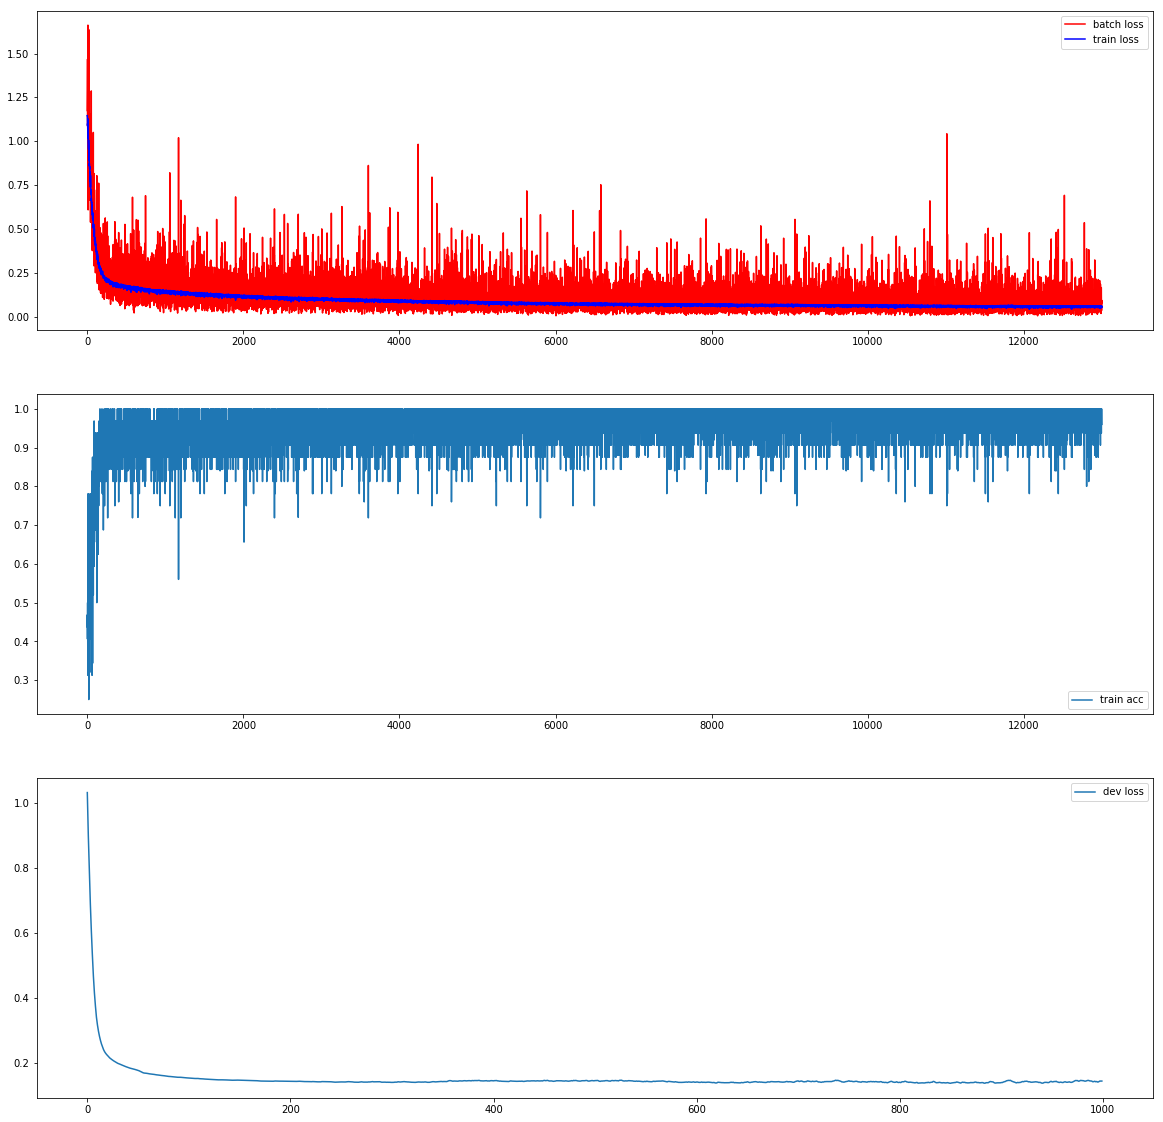

In [45]:
f,axes = plt.subplots(3,1,figsize=(20,20))
axes = axes.flatten()
axes[0].plot(batch_ls, 'r', label='batch loss')
axes[0].plot(train_ls, 'b', label='train loss')
axes[1].plot(batch_accs, label='train acc')

axes[2].plot(dev_ls, label='dev loss') #Devset error

for ax in axes:
    ax.legend(loc='best')
    
print(f"Train batch losses: {train_ls[0], train_ls[-1]}")
print(f"Train acc: {batch_accs[0], batch_accs[-1]}")

print(f"Dev loss: {dev_ls[0], dev_ls[-1]}")
print(f"Dev acc: {dev_accs[0], dev_accs[-1]}")

Devset error

In [47]:
#Test loop
# test loss
# with torch.no_grad():
#     for i, (xtest, ytest, _) in enumerate(test_loader):
#         n_test = len(test_loader.dataset)
#         assert (n_test == test_loader.batch_size)
        
#         ypred = model(xtest).view(ytest.size())
#         test_l = criterion(ypred, ytest).item()

#         # make a decision at 0.5
#         decision = (ypred > 0.5).type(ytest.dtype)
#         # collect isCorrects
#         isCorrect = (decision==ytest).numpy()


#         print('test loss: ', test_l)
#         print('acc: ', test_hit_accs)

test_l, test_acc, test_hit_accs = get_loss_on_entire_dataset(model, 
                                                              criterion, 
                                                              loader=test_loader)
print('test loss: ', test_l)
print('test acc: ', test_acc)
print('test_hit_accs: ', test_hit_accs)

test loss:  0.18106326460838318
test acc:  0.9122807017543859
test_hit_accs:  [0.9166666666666666, 0.9047619047619048]
